<a href="https://colab.research.google.com/github/yeabwang/malaria-diagnosis/blob/main/Malaria_diagnosis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This model os a binary classification model which classifies cells as infected or not infected.
# Dataset to be used https://lhncbc.nlm.nih.gov/LHC-downloads/downloads.html#malaria-datasets
##### 27,558 cell images - from thin blood smear slides - contains both infected and uninfected cells.

In [22]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

In [3]:
dataset,dataset_info = tfds.load('malaria',as_supervised=True,with_info=True, shuffle_files = True,split=['train'])

In [4]:
# Spliting our dataset into trianing, validation and testing

def split_dataset(dataset,train_ratio,val_ratio,test_ratio):
    dataset_size = len(dataset)

    train_dataset = dataset.take(int(train_ratio*dataset_size))  #grabbing our training dataset
    val_test_dataset = dataset.skip(int(train_ratio*dataset_size)) #grabbing the data left from the training dataset
    val_dataset = val_test_dataset.take(int(val_ratio*dataset_size)) #grabbing the validation set
    test_dataset = val_test_dataset.skip(int(val_ratio*dataset_size)) #grabbing the test dataset

    return train_dataset,val_dataset,test_dataset


In [5]:
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

train_dataset,val_dataset,test_dataset = split_dataset(dataset[0],train_ratio,val_ratio,test_ratio)
# print(list(train_dataset.take(1).as_numpy_iterator())), list(val_dataset.take(1).as_numpy_iterator()), list(test_dataset.take(1).as_numpy_iterator())

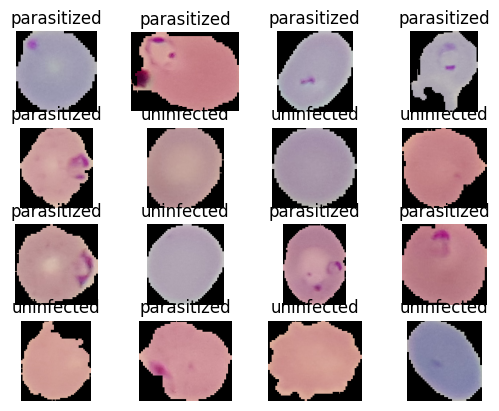

In [6]:
# Ploting some of the datas we have in our datset
for i,(image,label) in enumerate(train_dataset.take(16)):
  ax = plt.subplot(4,4,i+1)
  plt.imshow(image)
  plt.title(dataset_info.features['label'].int2str(label))
  plt.axis('off')

In [7]:
# Resizing and Rescaling

image_size = 224

def resize_rescale(image,label):
  return tf.image.resize(image,[image_size,image_size])/255.0,label

train_dataset = train_dataset.map(resize_rescale)

In [8]:
#shuffling and taking a batch of our dataset

train_dataset = train_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)

In [26]:
# Creating a our CNN model

image_size = 224
channel_size = 3

model = Sequential([
    InputLayer(input_shape=(image_size, image_size, channel_size)),

    Conv2D(filters=6, kernel_size=5, strides=1, padding='valid', activation='sigmoid'),
    MaxPooling2D(pool_size=2, strides=2),

    Conv2D(filters=16, kernel_size=5, strides=1, padding='valid', activation='sigmoid'),
    MaxPooling2D(pool_size=2, strides=2),

    Flatten(),

    Dense(1000, activation='sigmoid'),
    #Dropout(0.5),
    Dense(100, activation='sigmoid'),
    #Dropout(0.5),
    Dense(2, activation='sigmoid')
])

# Compile model with Adam optimizer
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_17 (Conv2D)                   │ (None, 220, 220, 6)         │             456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 110, 110, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 106, 106, 16)        │           2,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 53, 53, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_8 (Flatten)                  │ (None, 44944)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 1000)                │      44,945,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 100)                 │         100,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 2)                   │             202 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 45,048,174 (171.85 MB)

 Trainable params: 45,048,174 (171.85 MB)

 Non-trainable params: 0 (0.00 B)